# Hierarchical HMM: Chords & Song Sections

## Data Cleaning & Augmentation
Simplifying chords down to 42: base note (A-G) + accidental + major/minor(dim).

In [38]:
import pandas as pd

notes = ["A", "B", "C", "D", "E", "F", "G"]
accs = ["b", "s", ""]
all_notes_list = [note + acc for note in notes for acc in accs]

def simplify_chord(chord: str) -> str:
    """
    Removes chord quality from a chord.
    """
    for note in all_notes_list:
        if not chord.startswith(note):
            continue

        suffix = chord.removeprefix(note)
        if suffix.startswith("min") or suffix.startswith("dim"):
            return note + "min"
        else:
            return note

    if chord == "sC":
        return "Cs"

    return ""


def expand_sections(tokens):
    """
    Given token list ["<intro_1>", "C", "<verse_1>", "F", "C", "G7", ...]
    Returns list of replicated section labels ["intro", "intro", "verse", "verse", "verse", "verse", ...]
    """
    section_labels = []
    current_section = None

    for tok in tokens:
        if tok.startswith("<") and tok.endswith(">"):
            raw = tok[1:-1] # drop <>
            current_section = raw.split("_")[0] # intro_1 --> intro
        else:
            section_labels.append(current_section) # replicate current section label if it's a chord
    return section_labels


##### Main Processing #####

df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv", usecols=["chords", "main_genre"])

# filter only pop songs
pop_df = df[df["main_genre"] == "pop"].copy()
pop_df["tokens"] = pop_df["chords"].str.split(" ")

# remove all songs with no section tags
pop_df = pop_df[
    pop_df["chords"].apply(
        lambda tokens: any(token.startswith("<") for token in tokens)
    )
].copy()

print("After filtering:", len(pop_df))  # 55k

pop_df["simple_chords"] = pop_df["tokens"].apply(
    lambda toks: [simplify_chord(tok) for tok in toks if not tok.startswith("<")]
)

pop_df["sections"] = pop_df["tokens"].apply(expand_sections)

# sanity check
assert all(
    len(c) == len(s)
    for c, s in zip(pop_df["simple_chords"], pop_df["sections"])
), "Mismatched chord-section lengths"

print(pop_df.head())

/var/folders/d6/01g3p5bx5m1cs2jjn1_kw59c0000gn/T/ipykernel_2362/3823867086.py:46: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv", usecols=["chords", "main_genre"])


After filtering: 55641
                                              chords main_genre  \
0  <intro_1> C <verse_1> F C E7 Amin C F C G7 C F...        pop   
4  <intro_1> C <verse_1> G C G C <chorus_1> F Dmi...        pop   
6  <intro_1> G Bmin Amin D G Bmin <verse_1> Amin ...        pop   
7  <intro_1> Fsmin Fsno3d Bno3d E/B Fsno3d Bno3d ...        pop   
8  <chorus_1> C Amin Dmin G C G Amin Dmin G C <ve...        pop   

                                              tokens  \
0  [<intro_1>, C, <verse_1>, F, C, E7, Amin, C, F...   
4  [<intro_1>, C, <verse_1>, G, C, G, C, <chorus_...   
6  [<intro_1>, G, Bmin, Amin, D, G, Bmin, <verse_...   
7  [<intro_1>, Fsmin, Fsno3d, Bno3d, E/B, Fsno3d,...   
8  [<chorus_1>, C, Amin, Dmin, G, C, G, Amin, Dmi...   

                                       simple_chords  \
0  [C, F, C, E, Amin, C, F, C, G, C, F, C, E, Ami...   
4  [C, G, C, G, C, F, Dmin, G, Dmin, G, C, G, C, ...   
6  [G, Bmin, Amin, D, G, Bmin, Amin, D, G, Emin, ...   
7  [Fsmin, Fs

In [39]:
num_chords = pop_df['simple_chords'].str.len()
print(num_chords.mean())

84.27549828363976


In [40]:
# Split train & test
pop_df_train = pop_df.iloc[:50000]
pop_df_test = pop_df.iloc[50000:]

In [41]:
# Extract chords by section label -> one dataframe per label
all_sections = set(
    tag
    for tags in pop_df_train["sections"]
    for tag in tags
)
print("Observed sections:", str(all_sections))
print(len(all_sections))

# section -> df with column "chords"
section_dfs = {}
for section in all_sections:
    song_chords_per_sect = []

    for chords, secs in zip(pop_df_train["simple_chords"], pop_df_train["sections"]):
        # indices where the section appears
        idxs = [i for i, s in enumerate(secs) if s == section]

        # don't record in df if the song doesn't have the section
        if not idxs:
            continue

        # extract the chords at these indices
        seq = [chords[i] for i in idxs]

        song_chords_per_sect.append(seq)

    section_dfs[section] = pd.DataFrame({"chords": song_chords_per_sect})


for section in all_sections:
    print(f"\nSection: {section}")
    print(section_dfs[section].head())
    print("Num rows:", len(section_dfs[section]))

Observed sections: {'solo', 'intro', 'outro', 'chorus', 'interlude', 'verse', 'instrumental', 'bridge'}
8

Section: solo
                                              chords
0                                                [D]
1                                       [C, G, D, G]
2                                 [Amin, C, D, Amin]
3                  [D, Bmin, G, A, D, Bmin, G, A, D]
4  [Amin, F, Amin, F, Amin, F, Amin, G, F, Amin, ...
Num rows: 2284

Section: intro
                                  chords
0                                    [C]
1                                    [C]
2            [G, Bmin, Amin, D, G, Bmin]
3  [Fsmin, Fs, B, E, Fs, B, E, Fsmin, B]
4                           [C, C, C, C]
Num rows: 33084

Section: outro
                                              chords
0  [Amin, D, G, Emin, Amin, D, G, Emin, Amin, D, ...
1                         [B, E, Fsmin, B, E, Fsmin]
2               [Dmin, G, C, Amin, Dmin, G, C, G, C]
3                                       

In [42]:
# Add EOS section label
def add_EOS(tokens):
    return tokens + ["EOS"]

pop_df_train.loc[:, 'sections'] = pop_df_train['sections'].apply(add_EOS)

# Learning
Compute n-gram counts using CountVectorizer library

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

def count_n_grams(data, n: int = 1) -> pd.DataFrame:
    word_vectorizer = CountVectorizer(
        ngram_range=(1, n),
        analyzer="word",
        token_pattern=r"(?u)\b\w+\b",
        lowercase=False,
    )

    sparse_matrix = word_vectorizer.fit_transform(
        data.map(lambda chords: " ".join(chords))
    )

    frequencies = sum(sparse_matrix).toarray()[0]

    df_all = pd.DataFrame(
        frequencies,
        index=word_vectorizer.get_feature_names_out(),
        columns=["count"],
    )

    return df_all.groupby(by=lambda chords: len(chords.split(" ")))

In [44]:
import itertools

# Calculate transition matrix probabilities
# alpha is additive smoothing
def compute_unigram_prob(n_gram_counts, vocab, alpha=1.0):
    unigram = n_gram_counts.get_group(1).copy()
    unigram = unigram.reindex(vocab, fill_value=0)
    vocab_size = len(vocab)
    total_count = unigram["count"].sum()

    probs = (unigram["count"] + alpha) / (total_count + alpha * vocab_size)
    df = pd.DataFrame([probs.values], 
                      index=[""],
                      columns=vocab)
    return df

def compute_ngram_prob(n_gram_counts, vocab, n : int = 2, alpha=1.0):
    ngram = n_gram_counts.get_group(n).copy()

    ngram["evidence"] = ngram.index.map(lambda s: " ".join(s.split()[:-1]))
    ngram["next"] = ngram.index.map(lambda s: s.split()[-1])
    
    # generate all possible (n-1)-length chord sequeneces
    all_evidence_seq = [" ".join(evidence) for evidence in itertools.product(vocab, repeat=(n - 1))]
    full_index = pd.MultiIndex.from_product([all_evidence_seq, vocab], names=["evidence", "next"])

    # reindex to (vocab_size^(n-1), n)
    ngram = ngram.set_index(["evidence", "next"])
    ngram = ngram.reindex(full_index, fill_value=0)

    # compute probs
    evidence_counts = ngram["count"].groupby(level="evidence").transform("sum")
    vocab_size = len(vocab)
    ngram["prob"] = (ngram["count"] + alpha) / (evidence_counts + alpha * vocab_size)

    # 2d df transition matrix
    return ngram["prob"].unstack(fill_value=0.0)

Compute n-gram counts for section labels

In [45]:
# Sections

n = 2 # S_t+1 only depends on S_t

pop_sections = pop_df_train['sections']
n_gram_cnts = count_n_grams(pop_sections, n)
for key, _ in n_gram_cnts:
    print(n_gram_cnts.get_group(key).sort_values(by='count'), "\n\n")

                count
solo            26787
EOS             50000
instrumental    72561
interlude       73513
outro          210946
bridge         272254
intro          276919
verse         1595950
chorus        1691970 


                     count
solo intro               3
solo instrumental        6
outro interlude          8
outro bridge            12
instrumental solo       15
...                    ...
outro outro         189002
intro intro         242894
bridge bridge       246820
verse verse        1496771
chorus chorus      1581446

[72 rows x 1 columns] 




In [46]:
all_sections = list(set(
    tag
    for tags in pop_df_train["sections"]
    for tag in tags
))
print("All sections:", str(all_sections))
print(len(all_sections))

# Section unigram probs
unigram_probs_sec = compute_unigram_prob(n_gram_cnts, all_sections)
print(unigram_probs_sec.shape)
unigram_probs_sec

All sections: ['solo', 'intro', 'outro', 'chorus', 'EOS', 'interlude', 'verse', 'instrumental', 'bridge']
9
(1, 9)


,solo,intro,outro,chorus,EOS,interlude,verse,instrumental,bridge
,0.006272,0.064839,0.049392,0.396162,0.011707,0.017213,0.373679,0.01699,0.063746


In [47]:
# Section bigram probs
bigram_probs_sec = compute_ngram_prob(n_gram_cnts, all_sections, n=2)
print(bigram_probs_sec.shape)
bigram_probs_sec

(9, 9)


next,EOS,bridge,chorus,instrumental,interlude,intro,outro,solo,verse
evidence,,,,,,,,,
EOS,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
bridge,0.005245,0.906554,0.061088,0.002777,0.002156,0.000187,0.008150,0.001065,0.012778
chorus,0.012342,0.010569,0.934673,0.003738,0.003622,0.000312,0.009079,0.000978,0.024688
instrumental,0.008419,0.016040,0.030012,0.873515,0.000868,0.000372,0.011410,0.000220,0.059143
interlude,0.005522,0.011833,0.028971,0.001020,0.877520,0.000286,0.008052,0.001143,0.065654
intro,0.002658,0.000459,0.011252,0.000636,0.000617,0.877105,0.000469,0.000235,0.106569
outro,0.100657,0.000062,0.000280,0.000488,0.000043,0.001659,0.895940,0.000123,0.000749
solo,0.011046,0.011308,0.033736,0.000261,0.001157,0.000149,0.008098,0.903120,0.031124
verse,0.002766,0.003126,0.052115,0.001009,0.001227,0.000054,0.001594,0.000256,0.937851


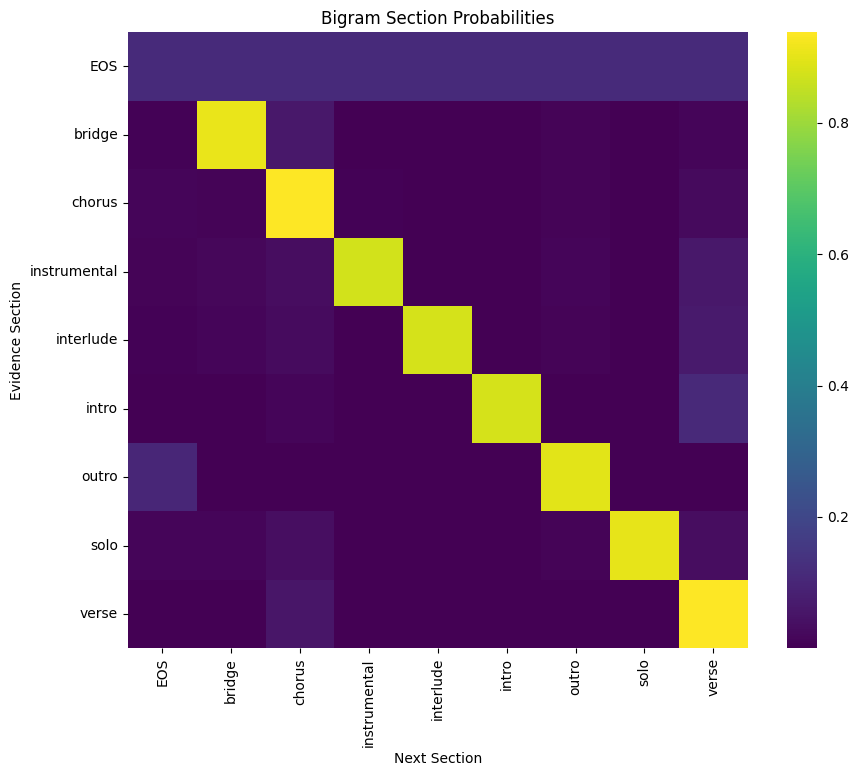

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(bigram_probs_sec, cmap="viridis")
plt.title("Bigram Section Probabilities")
plt.xlabel("Next Section")
plt.ylabel("Evidence Section")
plt.show()

Compute n-gram counts for chords

In [49]:
# Vocabulary of all possible chords (flats consolidated with sharps)
notes = ["A", "B", "C", "D", "E", "F", "G"]
accs = ["b", "s", ""]
third = ["", "min"]
all_chords = [note + acc + t for note in notes for acc in accs for t in third]

In [50]:
n = 4
section_n_gram_counts = {} # index: section_n_gram_counts["intro"][1]
section_n_gram_probs = {}

for section, section_df in section_dfs.items():
    # for song chords in each section, get n_gram counts
    chord_series = section_df["chords"]

    counts_df = count_n_grams(chord_series, n)
    section_n_gram_counts[section] = counts_df

    # compute transition probabilities for each n
    section_n_gram_probs[section] = {}

    # unigram
    unigram_probs = compute_unigram_prob(counts_df, all_chords)
    section_n_gram_probs[section][1] = unigram_probs

    # bigrams
    if n >= 2:
        bigram_probs = compute_ngram_prob(counts_df, all_chords, n=2)
        section_n_gram_probs[section][2] = bigram_probs

    # trigrams
    if n >= 3:
        trigram_probs = compute_ngram_prob(counts_df, all_chords, n=3)
        section_n_gram_probs[section][3] = trigram_probs

    # 4-gram
    if n >= 4:
        trigram_probs = compute_ngram_prob(counts_df, all_chords, n=4)
        section_n_gram_probs[section][4] = trigram_probs

# sanity check
print("Sections processed:", list(section_n_gram_counts.keys()))

Sections processed: ['solo', 'intro', 'outro', 'chorus', 'interlude', 'verse', 'instrumental', 'bridge']


In [51]:
# Sample calls
chorus_unigrams = section_n_gram_probs["chorus"][1]
bridge_trigrams = section_n_gram_counts["bridge"].get_group(3)

# Inference
Probabilistic method

In [52]:
import numpy as np

# def deterministic_inference(evidence):
#     # evidence: string of n-1 space-separated chords
    
#     n = len(evidence.split()) + 1
#     ngram_probs = unigram_probs if n == 1 else (bigram_probs if n == 2 else trigram_probs)

#     if evidence not in ngram_probs.index:
#         raise KeyError(f"Evidence '{evidence}' not found in {n}-gram table")
    
#     row_probs = ngram_probs.loc[evidence]
#     return row_probs.idxmax() # returns next chord w highest prob, if there are several, the first one in col order

def probabilistic_inference(section, chord_evidence):
    # section: section label at previous time step
    # evidence: string of n-1 space-separated chords

    # infer next section label
    if section == "":
        row_probs = unigram_probs_sec.loc[""]
    else:
        row_probs = bigram_probs_sec.loc[section]
    cdf = np.cumsum(row_probs.values) # cumulative distribution over next possible section
    seed = np.random.rand()
    idx = np.searchsorted(cdf, seed)
    next_section = row_probs.index[idx]

    if next_section == "EOS": # end of song!
        return (next_section, "")
    
    # infer next chord
    n = len(chord_evidence.split()) + 1
    ngram_probs = section_n_gram_probs[next_section][n]

    if chord_evidence not in ngram_probs.index:
        raise KeyError(f"Evidence '{chord_evidence}' not found in {n}-gram table")
    
    row_probs = ngram_probs.loc[chord_evidence]
    cdf = np.cumsum(row_probs.values) # cumulative distribution over next possible chord
    seed = np.random.rand()
    idx = np.searchsorted(cdf, seed)
    next_chord = row_probs.index[idx]
    
    return (next_section, next_chord)

In [53]:
### test inference for bigram ###
section = ""
seq = []
section_seq = []

for _ in range(200): # hard stop
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    elif len(seq) == 2:
        evidence = " ".join(seq)
    else:
        evidence = " ".join(seq[-3:])

    next_section, next_chord = probabilistic_inference(section, evidence)

    if next_section == "EOS":
        break
    else:
        section = next_section
    
    section_seq.append(section)
    seq.append(next_chord)

print(seq)
print(section_seq)
print(len(seq), len(section_seq))

['Gsmin']
['outro']
1 1


# Evaluation
Evaluate log-likelihood of an n-gram given a song

In [54]:
def song_log_likelihood_ngram(song, section_seq, n, section_n_gram_probs):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: dict[context_tuple] -> dict[target] = P(target | context)
    # ex: trigram ngram_prob = dict[(chord1, chord2)] = {chord0:P,...,chordV:P}, dict[chord3] = P(chord3 | chord1, chord2)

    ll = 0.0
    if len(song) < n:
        return 0.0

    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])

        target = song[t]

        try:
            ngram_probs = section_n_gram_probs[section_seq[t]][n]
            p = ngram_probs.loc[context, target]
        except KeyError:
            print(f"KeyError given evidence {context}")
            p = 1e-12

        if p <= 0:
            p = 1e-12
        
        ll += np.log(p)

    return ll

In [55]:
# Remove EOS section label to compute log-likelihood
def remove_EOS(tokens):
    if tokens and tokens[-1] == "EOS":
        return tokens[:-1]
    return tokens

sections_series = pop_df_train['sections'].copy().apply(remove_EOS)
print(sections_series.head())

0    [intro, verse, verse, verse, verse, verse, ver...
4    [intro, verse, verse, verse, verse, chorus, ch...
6    [intro, intro, intro, intro, intro, intro, ver...
7    [intro, intro, intro, intro, intro, intro, int...
8    [chorus, chorus, chorus, chorus, chorus, choru...
Name: sections, dtype: object


In [56]:
# Compute per chord log-likelihood
# For training data, evaluate that log-likelihood increases as n increases
assert(
    len(pop_df_train["simple_chords"]) == len(sections_series)
), "Mismatched data points"

assert all(
    len(c) == len(s)
    for c, s in zip(pop_df_train["simple_chords"], sections_series)
), "Mismatched chord-section lengths"

def avg_log_likelihood_ngram(chords_series, sections_series, n):
    total_ll = 0.0
    for song, section_seq in zip(chords_series, sections_series):
        total_ll += song_log_likelihood_ngram(song, section_seq, n, section_n_gram_probs)

    total_length = sum(len(song) for song in chords_series)
    avg_ll = total_ll / total_length
    return avg_ll

In [57]:
unigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 1)
print("Unigram average log-likelihood per chord: " + str(unigram_avg_ll))

bigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 2)
print("Bigram average log-likelihood per chord: " + str(bigram_avg_ll))

Unigram average log-likelihood per chord: -2.9071487182931564
Bigram average log-likelihood per chord: -2.322537961449264


In [58]:
trigram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 3)
print("Trigram average log-likelihood per chord: " + str(trigram_avg_ll))

fourgram_avg_ll = avg_log_likelihood_ngram(pop_df_train['simple_chords'], sections_series, 4)
print("4-gram average log-likelihood per chord: " + str(fourgram_avg_ll))

Trigram average log-likelihood per chord: -1.9470278892035116
4-gram average log-likelihood per chord: -1.7339802955874384


These results make sense, since the log-likelihood per chord increases as n increases, indicating that predictions become more accurate with more context.

In [59]:
# now see if we are overfitting by computing log-like on test dataset
assert(
    len(pop_df_test["simple_chords"]) == len(pop_df_test['sections'])
), "Mismatched data points"

assert all(
    len(c) == len(s)
    for c, s in zip(pop_df_test["simple_chords"], pop_df_test['sections'])
), "Mismatched chord-section lengths"

unigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 1)
print("Unigram average log-likelihood per chord: " + str(unigram_avg_ll_test))

bigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 2)
print("Bigram average log-likelihood per chord: " + str(bigram_avg_ll_test))

trigram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 3)
print("Trigram average log-likelihood per chord: " + str(trigram_avg_ll_test))

fourgram_avg_ll_test = avg_log_likelihood_ngram(pop_df_test['simple_chords'], pop_df_test['sections'], 4)
print("4-gram average log-likelihood per chord: " + str(fourgram_avg_ll_test))

Unigram average log-likelihood per chord: -2.9321345681061537
Bigram average log-likelihood per chord: -2.3866940896881004
Trigram average log-likelihood per chord: -2.0337497282912445
4-gram average log-likelihood per chord: -1.900409339856628


These values are close to the log-likelihoods for the train dataset, which indicates that the model generalized well and does not overfit! Notice that the test log-likes are slightly worse, this makes sense since the model already saw the training data. These small differences also indicate that the distribution of chord transitions in held-out songs is very similar to those in training songs.

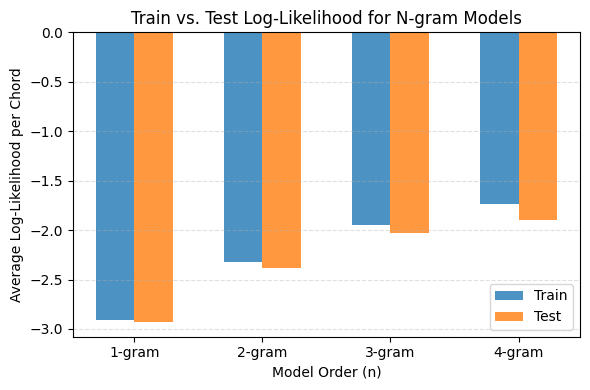

In [60]:
import matplotlib.pyplot as plt
import numpy as np

train_ll = [
    unigram_avg_ll,
    bigram_avg_ll,
    trigram_avg_ll,
    fourgram_avg_ll
]

test_ll = [
    unigram_avg_ll_test,
    bigram_avg_ll_test,
    trigram_avg_ll_test,
    fourgram_avg_ll_test
]

n_values = np.arange(1, 5)

# Bar plot
width = 0.3  # width of each bar
x = np.arange(len(n_values))

plt.figure(figsize=(6,4))

# train bars
plt.bar(x - width/2, train_ll, width, label="Train", alpha=0.8)

# test bars
plt.bar(x + width/2, test_ll, width, label="Test", alpha=0.8)

plt.xticks(x, [f"{i}-gram" for i in n_values])
plt.ylabel("Average Log-Likelihood per Chord")
plt.xlabel("Model Order (n)")
plt.title("Train vs. Test Log-Likelihood for N-gram Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [61]:
def top_k_accuracy_ngram(song, n, ngram_probs, k=5):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: DataFrame with index=evidence, columns=next chords
    # k: number of top predictions to consider
    
    correct = 0
    total = 0
    
    if len(song) < n:
        return 0.0
    
    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])
        
        target = song[t]
        
        try:
            prob_row = ngram_probs.loc[context]
            
            top_k_chords = prob_row.nlargest(k).index.tolist()
            
            if target in top_k_chords:
                correct += 1
            total += 1
            
        except KeyError:
            total += 1
    
    return correct / total if total > 0 else 0.0

In [62]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=5):.4f}")

Top-1: 0.0000
Top-3: 0.0000
Top-5: 0.0000


### Top-K Accuracy on Test Set

In [ ]:
def evaluate_hierarchical_top_k(df_test, section_n_gram_probs, n=2, k=5):
    
    top_1_correct = 0
    top_3_correct = 0
    top_5_correct = 0
    total_predictions = 0
    
    chords_series = df_test['simple_chords']
    sections_series = df_test['sections']
    
    for song_chords, song_sections in zip(chords_series, sections_series):
        if len(song_chords) < n: continue
        
        for i in range(n-1, len(song_chords)):
            if n == 1:
                context = ""
            else:
                context = " ".join(song_chords[i-(n-1):i])
            
            target = song_chords[i]
            section = song_sections[i] 
            
            if section in section_n_gram_probs and n in section_n_gram_probs[section]:
                probs_df = section_n_gram_probs[section][n]
                
                if context in probs_df.index:
                    row = probs_df.loc[context]
                    top_k_preds = row.nlargest(5).index.tolist()
                    
                    if target == top_k_preds[0]: top_1_correct += 1
                    if target in top_k_preds[:3]: top_3_correct += 1
                    if target in top_k_preds[:5]: top_5_correct += 1
                    
                    total_predictions += 1

    acc_1 = top_1_correct / total_predictions if total_predictions > 0 else 0
    acc_3 = top_3_correct / total_predictions if total_predictions > 0 else 0
    acc_5 = top_5_correct / total_predictions if total_predictions > 0 else 0
    
    return acc_1, acc_3, acc_5


Evaluating Hierarchical 1-gram Model...
Evaluating Hierarchical 2-gram Model...
Evaluating Hierarchical 3-gram Model...
Evaluating Hierarchical 4-gram Model...

Hierarchical Evaluation Results:
     Model      K  Accuracy
0   1-gram  Top-1  0.131060
1   1-gram  Top-3  0.340274
2   1-gram  Top-5  0.490368
3   2-gram  Top-1  0.220616
4   2-gram  Top-3  0.515364
5   2-gram  Top-5  0.705150
6   3-gram  Top-1  0.308765
7   3-gram  Top-3  0.646078
8   3-gram  Top-5  0.817620
9   4-gram  Top-1  0.390520
10  4-gram  Top-3  0.718376
11  4-gram  Top-5  0.842588


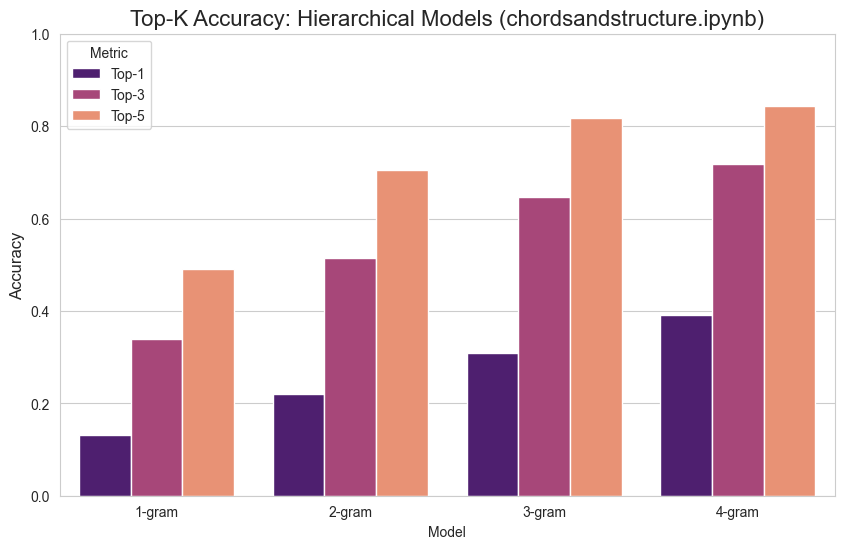

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

results_data = []

for n in range(1, 5):
    print(f"Evaluating Hierarchical {n}-gram Model...")
    # Using the evaluation function we added
    acc_1, acc_3, acc_5 = evaluate_hierarchical_top_k(pop_df_test, section_n_gram_probs, n=n, k=5)
    
    model_name = f"{n}-gram"
    results_data.append({"Model": model_name, "K": "Top-1", "Accuracy": acc_1})
    results_data.append({"Model": model_name, "K": "Top-3", "Accuracy": acc_3})
    results_data.append({"Model": model_name, "K": "Top-5", "Accuracy": acc_5})

# Plot
df_results = pd.DataFrame(results_data)
print("\nHierarchical Evaluation Results:")
print(df_results)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=df_results, x="Model", y="Accuracy", hue="K", palette="magma")
plt.title("Top-K Accuracy: Hierarchical Models (chordsandstructure.ipynb)", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title="Metric")
plt.show()